In [20]:
import torch
from torch import nn, optim
from torch import nn
from torch.nn import functional as F

from torch_geometric import datasets
from torch_geometric.data import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv

import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from hydra import compose, initialize

In [21]:
with initialize(version_base=None, config_path="./config"):
    config = compose(config_name="model.yaml")
    print(config)

{'dataset': {'name': 'Cora', 'save_path': '.'}, 'model': {'name': 'scratch', 'latent_dim': 256}, 'training': {'train_size_ratio': 0.8, 'save_path': './train_result', 'epochs': 1000, 'verbose': 10}}


In [22]:
cora = datasets.Planetoid(root=config.dataset.save_path, name=config.dataset.name, transform=NormalizeFeatures())

In [23]:
dataset = cora[0]
print(f"Number sample: {len(cora.x)}")
print(f"Number of features: {cora.num_features}")
print(f"Number of classes: {cora.num_classes}")
print(f"Number of nodes: {dataset.num_nodes}")
print(f"Number of training nodes: {dataset.train_mask.sum()}")
print(f"Is undirected? {dataset.is_undirected()}")

Number sample: 2708
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of training nodes: 140
Is undirected? True


In [24]:
edges = dataset.edge_index.t()

In [25]:
edges

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [26]:
labels = dataset.y

In [27]:
G = nx.Graph()
G.add_edges_from(edges.tolist())

In [28]:
color_map = {}
colors = ["blue", "green", "red", "yellow", "black", "orange", "magma"]
c_map = {i : colors[i] for i in range(7)}
nodes_color = []
nodes = []
for node in G:
  nodes.append(node)
  nodes_color.append(c_map[labels[node].item()])

In [29]:
carac = pd.DataFrame({"node" : nodes, "colors" : nodes_color})

carac['colors']=pd.Categorical(carac['colors'])
carac['colors'].cat.codes

0       6
1       6
2       6
3       6
4       0
       ..
2703    5
2704    0
2705    0
2706    0
2707    0
Length: 2708, dtype: int8

In [30]:
if not os.path.exists("./cora_graph.png"):
  plt.figure(figsize=(100, 50))
  pos = nx.kamada_kawai_layout(G)
  nx.draw(G, pos, node_color=carac['colors'].cat.codes, with_labels=True)
  plt.savefig("cora_graph.png", dpi=150, bbox_inches="tight")
  plt.show()
else:
  print("./cora_graph.png")

./cora_graph.png


In [31]:
TRAIN_LIMIT = int(config.training.train_size_ratio * len(cora.x))
TEST_LIMIT = int((1 - config.training.train_size_ratio) * len(cora.x))

## Define model

In [32]:
class GNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        """The module is a GNN model which is based on the GCN layer

        Parameters
        ----------
        input_size : The number of features of one node in the graph
        hidden_size : The latent dim for hidden layer
        output_size : the number of classes which is needed to classify
        """
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, X, edges_index):
        out = X
        out = self.conv1(out, edges_index)
        out = out.relu()
        out = F.dropout(out, p=0.5, training=self.training)

        out = self.conv2(out, edges_index)
        out = out.relu()
        out = F.dropout(out, p=0.5, training=self.training)

        out = self.conv3(out, edges_index)
        out = out.relu()
        out = F.dropout(out, p=0.5, training=self.training)

        out = self.out(out)
        out = F.softmax(out, dim=1)
        return out

    def get_parameters(self):
        return sum(parameter.numel() for parameter in self.parameters())

    def __str__(self):
        return (
            super(GNN, self).__str__()
            + f"\nNumber of parameters: {self.get_parameters():,}"
        )

In [33]:
LATENT_DIM = config.model.latent_dim
model = GNN(cora.num_features, LATENT_DIM, cora.num_classes)

In [34]:
print(model)

GNN(
  (conv1): GCNConv(1433, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (out): Linear(in_features=256, out_features=7, bias=True)
)
Number of parameters: 500,487


## Training

In [35]:
EPOCHS = config.training.epochs
VERBOSE = config.training.verbose
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
dataset = dataset.to(device)

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
history = {
  "epoch" : [],
  "loss" : []
}

for epoch in range(1, EPOCHS + 1):
  model.train()
  optimizer.zero_grad()
  out = model(dataset.x, dataset.edge_index)
  loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])
  loss.backward()
  optimizer.step()
  history["epoch"].append(epoch)
  history["loss"].append(loss.cpu().detach().item())
  
  print(f"Epoch {epoch} | Loss: {loss.item()}")

Epoch 1 | Loss: 1.9459257125854492
Epoch 2 | Loss: 1.9458321332931519
Epoch 3 | Loss: 1.9457110166549683
Epoch 4 | Loss: 1.9456148147583008
Epoch 5 | Loss: 1.9454435110092163
Epoch 6 | Loss: 1.9452974796295166
Epoch 7 | Loss: 1.9449386596679688
Epoch 8 | Loss: 1.9447760581970215
Epoch 9 | Loss: 1.9444669485092163
Epoch 10 | Loss: 1.9438674449920654
Epoch 11 | Loss: 1.9433262348175049
Epoch 12 | Loss: 1.9428495168685913
Epoch 13 | Loss: 1.942085862159729
Epoch 14 | Loss: 1.9409892559051514
Epoch 15 | Loss: 1.9402265548706055
Epoch 16 | Loss: 1.9388659000396729
Epoch 17 | Loss: 1.9373219013214111
Epoch 18 | Loss: 1.9353125095367432
Epoch 19 | Loss: 1.9336005449295044
Epoch 20 | Loss: 1.930109977722168
Epoch 21 | Loss: 1.9273219108581543
Epoch 22 | Loss: 1.9242717027664185
Epoch 23 | Loss: 1.9184777736663818
Epoch 24 | Loss: 1.9153512716293335
Epoch 25 | Loss: 1.905543565750122
Epoch 26 | Loss: 1.8996455669403076
Epoch 27 | Loss: 1.8929870128631592
Epoch 28 | Loss: 1.8823390007019043
Epoc

In [38]:
history_df = pd.DataFrame(history)

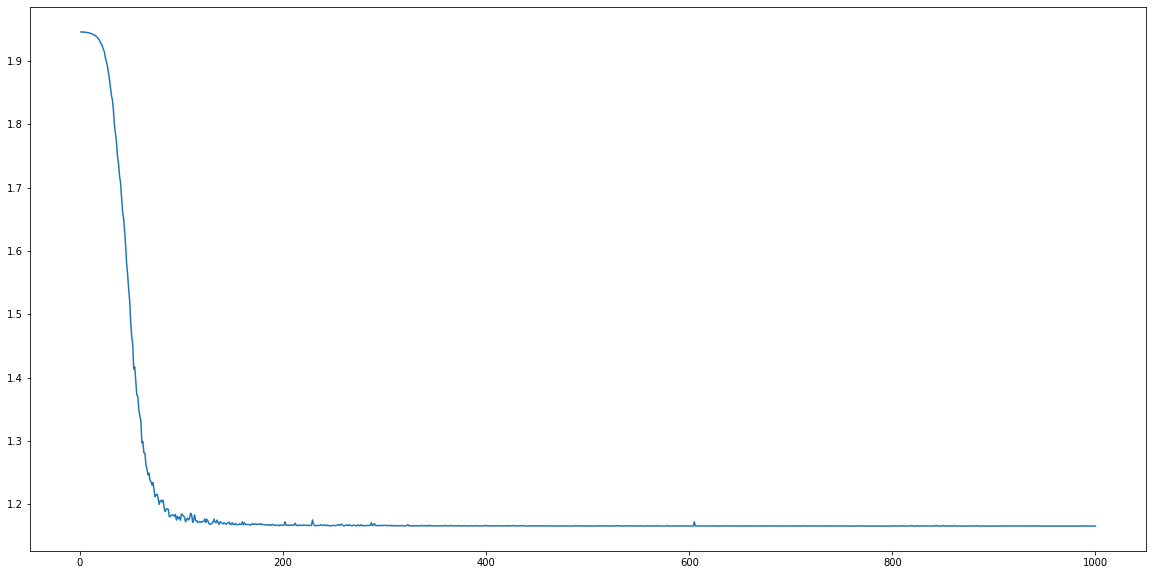

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(history["epoch"], history["loss"])

In [40]:
model.eval()
out = model(dataset.x, dataset.edge_index)
pred = out.argmax(dim = 1)
test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
accuracy = test_correct.sum() / dataset.test_mask.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.7580000162124634


## Test

Text(0, 0.5, 'Probability')

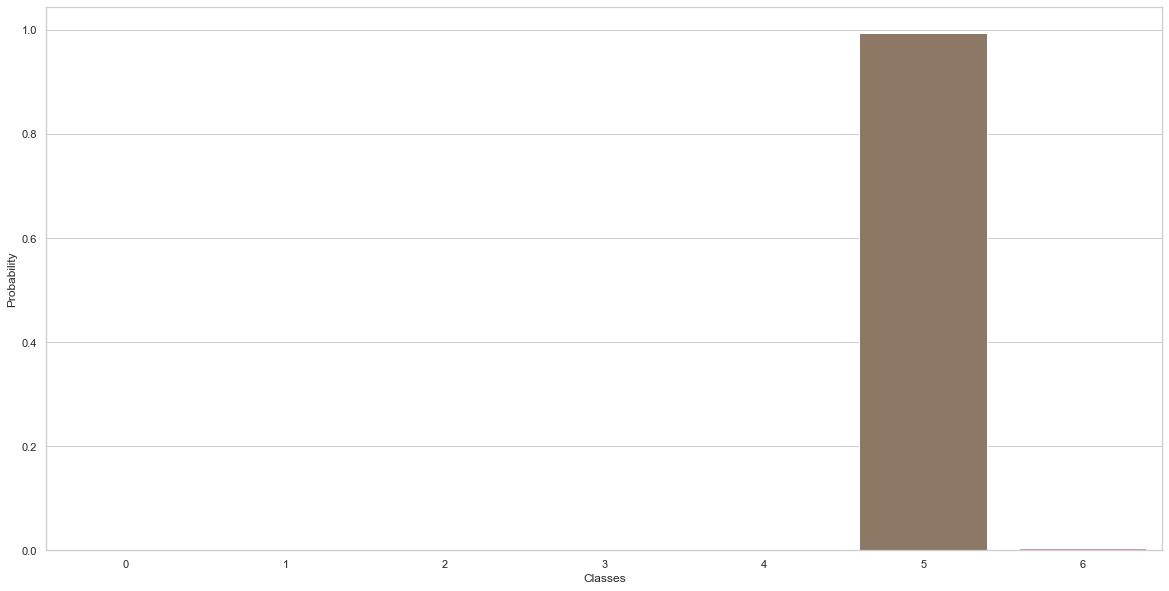

In [41]:
import random
sample_index = random.randint(0, dataset.test_mask.sum()) 
sample = dataset.x[dataset.test_mask]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
pred = model(dataset.x, dataset.edge_index)
ax = sns.barplot(x=np.array(range(7)), y=pred[sample_index].detach().cpu().numpy())
ax.set_xlabel("Classes")
ax.set_ylabel("Probability")